In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
# import pyodbc
# pyodbc.drivers()
# conn = pyodbc.connect("Driver={ODBC Driver 18 for SQL Server};Server=PostgreSQL 15 (localhost:5432);UID=postgres;PWD=87316130;Database=postgres;", timeout=120)

In [2]:
FOLDER_PATH = '/Users/ting/Documents/dvd_rental_csvs'

In [27]:
os.listdir(FOLDER_PATH)

['.DS_Store',
 'staff.csv',
 'customer_reviews.csv',
 'actor.csv',
 'film.csv',
 'film_category.csv',
 'customer.csv',
 'language.csv',
 'film_actor.csv',
 'address.csv',
 'city.csv',
 'country.csv',
 'payment.csv',
 'employees.csv',
 'category.csv',
 'rental.csv',
 'store.csv',
 'inventory.csv']

In [3]:
tables = {}
for filename in os.listdir(FOLDER_PATH):
    if filename.endswith('.csv'):
        print(filename)
        filename_without_extension = os.path.splitext(filename)[0]
        tables[filename_without_extension] = pd.read_csv(os.path.join(FOLDER_PATH, filename), on_bad_lines='skip')


staff.csv
customer_reviews.csv
actor.csv
film.csv
film_category.csv
customer.csv
language.csv
film_actor.csv
address.csv
city.csv
country.csv
payment.csv
employees.csv
category.csv
rental.csv
store.csv
inventory.csv


In [4]:
rental_df = tables['rental']
customer_df = tables['customer']
address_df = tables['address']
city_df = tables['city']
country_df = tables['country']

In [7]:
#Create a time-series plot showing daily total revenue for three different countries 


# find the country of each customer
customer_country_df = customer_df.merge(
    address_df[['address_id','city_id']],
    on=['address_id'],
    how='left'
).merge(
    city_df[['city_id', 'country_id']],
    on=['city_id'],
    how='left'
).merge(
    country_df[['country_id', 'country']],
    on=['country_id'],
    how='left'
).drop(columns=['store_id', 'email', 'address_id', 'activebool', 'create_date', 'last_update', 'active', 'city_id'])

In [11]:
payment_df = tables['payment']
df = payment_df[['customer_id', 'amount', 'payment_date']]
df['payment_date'] = pd.to_datetime(df['payment_date']).dt.date
revenue_country_date_df = df.merge(
    customer_country_df, on='customer_id'
).drop(
    columns={'customer_id', 'first_name', 'last_name'}
)

/var/folders/f6/kqlkz1b54f3gbqk59x88s6tr0000gp/T/ipykernel_66632/2763911096.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['payment_date'] = pd.to_datetime(df['payment_date']).dt.date


In [13]:
revenue_country_date_df

,amount,payment_date,country_id,country
0,7.99,2007-02-15,67,Netherlands
1,1.99,2007-02-16,67,Netherlands
2,7.99,2007-02-16,67,Netherlands
3,2.99,2007-02-19,67,Netherlands
4,7.99,2007-02-20,67,Netherlands
...,...,...,...,...
14591,4.99,2007-04-29,38,Germany
14592,0.99,2007-04-29,38,Germany
14593,6.99,2007-04-30,38,Germany
14594,5.99,2007-04-30,38,Germany


In [15]:
country_df.head()

,country_id,country,last_update
0,1,Afghanistan,2006-02-15 09:44:00
1,2,Algeria,2006-02-15 09:44:00
2,3,American Samoa,2006-02-15 09:44:00
3,4,Angola,2006-02-15 09:44:00
4,5,Anguilla,2006-02-15 09:44:00


In [17]:
#To randomly assign three countries for the analysis
NUM_COUNTRIES = 3
np.random.seed(42)
random_country_ids = np.random.choice(country_df['country_id'].unique(), NUM_COUNTRIES)
random_country_df = country_df[country_df['country_id'].isin(random_country_ids)]

In [18]:
random_country_df.head()

,country_id,country,last_update
51,52,Kenya,2006-02-15 09:44:00
92,93,Tanzania,2006-02-15 09:44:00
102,103,United States,2006-02-15 09:44:00


In [19]:
revenue_date_by_country_dict = {}
for i in range(NUM_COUNTRIES):
    country_id = random_country_df.iloc[i]['country_id']
    country = random_country_df.iloc[i]['country']
    revenue_date_ser = revenue_country_date_df[revenue_country_date_df['country_id'] == country_id].groupby(
        'payment_date')['amount'].sum()
    revenue_date_by_country_dict[country] = revenue_date_ser

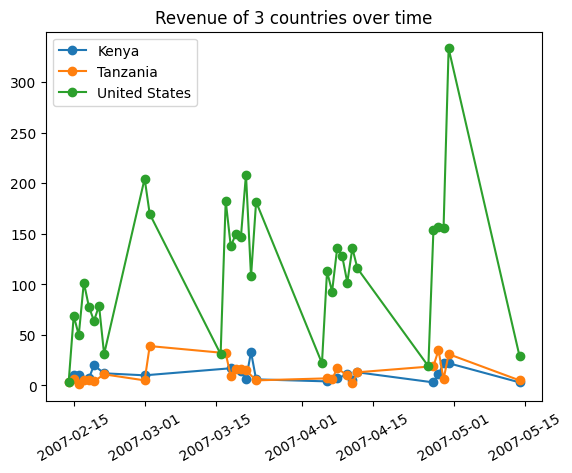

In [20]:
for country, ser in revenue_date_by_country_dict.items():
    plt.plot(ser, '-o', label=country)
plt.title('Revenue of 3 countries over time')
plt.xticks(rotation=30)
plt.legend()
plt.show()

In [ ]:
# a sentiment analysis on movie descriptions adding another column to the data frame that provides a sentiment classification. 

In [55]:
def sentiment_detection(sentence):
    positive_words = ('happy', 'sunny', 'positive', 'triumphant', 'optimistic', 'wonderful')
    negative_words = ('sad', 'terrible', 'frightening', 'rainy', 'scary')

    positive = any(sentence.count(i) > 0 for i in positive_words)
    negative = any(sentence.count(i) > 0 for i in negative_words)

    if positive == negative == False:
        return "neutral"
    elif positive != negative:
        return "positive" if positive else "negative"
    else:
        return "mixed"

In [56]:
sentence = 'happy and positive'
sentiment_detection(sentence)

'positive'

In [58]:
film_df['description'].apply(sentiment_detection)

0      neutral
1      neutral
2      neutral
3      neutral
4      neutral
        ...   
748    neutral
749    neutral
750    neutral
751    neutral
752    neutral
Name: description, Length: 753, dtype: object

In [60]:
sentiment_film_df = film_df.copy()

In [61]:
sentiment_film_df['sentiment'] = sentiment_film_df['description'].apply(sentiment_detection)

In [62]:
sentiment_film_df.head()

,film_id,title,description,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rating,last_update,special_features,fulltext,sentiment
0,133,Chamber Italian,A Fateful Reflection of a Moose And a Husband ...,2006,1,7,4.99,117,14.99,NC-17,2013-05-26 14:50:58.951,{Trailers},'chamber':1 'fate':4 'husband':11 'italian':2 ...,neutral
1,384,Grosse Wonderful,A Epic Drama of a Cat And a Explorer who must ...,2006,1,5,4.99,49,19.99,R,2013-05-26 14:50:58.951,"{'Behind the Scenes'""}""",'australia':18 'cat':8 'drama':5 'epic':4 'exp...,neutral
2,8,Airport Pollock,A Epic Tale of a Moose And a Girl who must Con...,2006,1,6,4.99,54,15.99,R,2013-05-26 14:50:58.951,{Trailers},'airport':1 'ancient':18 'confront':14 'epic':...,neutral
3,98,Bright Encounters,A Fateful Yarn of a Lumberjack And a Feminist ...,2006,1,4,4.99,73,12.99,PG-13,2013-05-26 14:50:58.951,{Trailers},'boat':20 'bright':1 'conquer':14 'encount':2 ...,neutral
4,2,Ace Goldfinger,A Astounding Epistle of a Database Administrat...,2006,1,3,4.99,48,12.99,G,2013-05-26 14:50:58.951,"{Trailers,'Deleted Scenes'""}""",'ace':1 'administr':9 'ancient':19 'astound':4...,neutral


In [ ]:
#a visual in the notebook that shows how much revenue is coming from different countries to the DVD store

In [48]:
revenue_by_country_ser = revenue_country_date_df.groupby('country')['amount'].sum()

In [49]:
revenue_by_country_ser

country
Afghanistan              67.82
Algeria                 349.18
American Samoa           47.85
Angola                  187.55
Anguilla                 99.68
                         ...  
Vietnam                 676.45
Virgin Islands, U.S.    121.69
Yemen                   473.93
Yugoslavia              233.49
Zambia                  121.70
Name: amount, Length: 108, dtype: float64

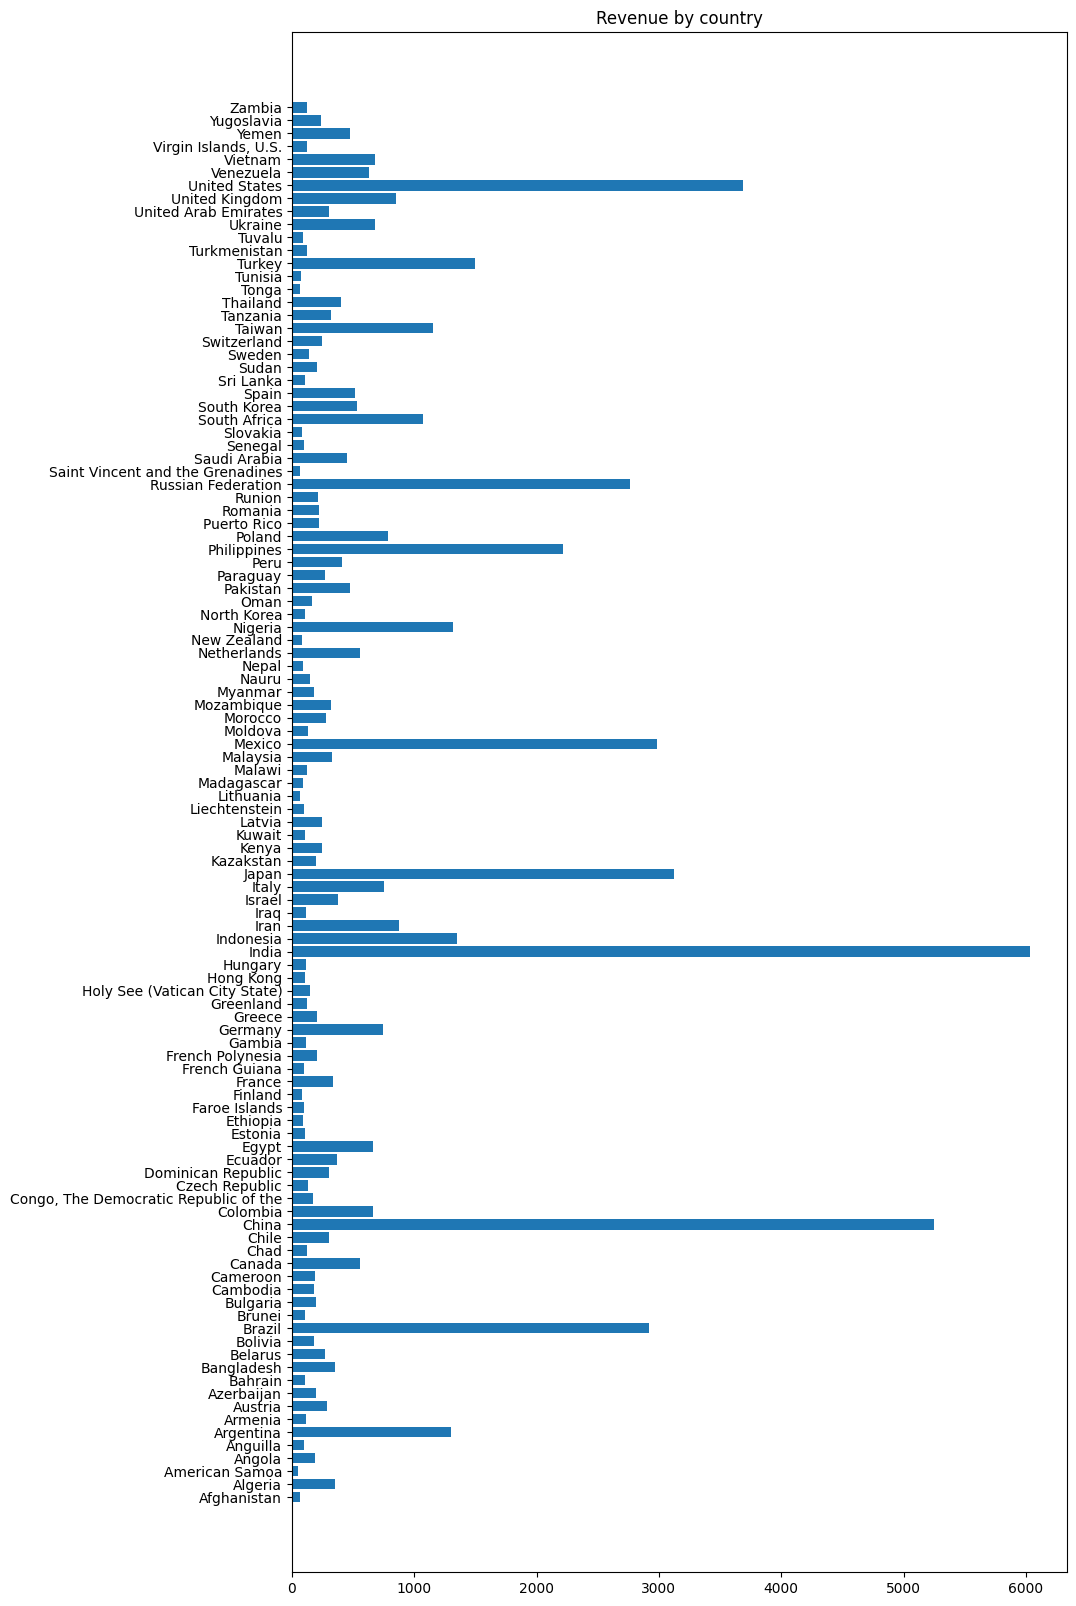

In [23]:
plt.figure(figsize=(10, 20))
plt.barh(revenue_by_country_ser.index, revenue_by_country_ser)
plt.title('Revenue by country')
plt.show()

In [ ]:
#an analysis to show which actors are bringing in the most revenue (top 10 ranked)

In [25]:

film_df = tables['film']
inventory_df = tables['inventory']
rental_df = tables['rental']
payment_df = tables['payment']
actor_df = tables['actor']
film_actor_df = tables['film_actor']

In [26]:
revenue_film_ser = payment_df[['rental_id', 'amount']].merge(
    rental_df[['rental_id', 'inventory_id']],
    on='rental_id',
    how='left'
).merge(
    inventory_df[['inventory_id', 'film_id']],
    on='inventory_id',
    how='left'
).drop(
    columns=['rental_id', 'inventory_id']
).groupby('film_id')['amount'].sum()

In [92]:
actor_film_df = actor_df[['actor_id', 'first_name', 'last_name']].merge(
    film_actor_df[['actor_id', 'film_id']],
    on='actor_id',
    how='left'
)

In [109]:
actor_df[['actor_id', 'first_name', 'last_name']].merge(
    actor_film_df.merge(
    revenue_film_ser, left_on='film_id', right_index=True,
    ).groupby('actor_id')['amount'].sum(),
    left_on='actor_id',
    right_index=True
).sort_values(by='amount', ascending=False).head(10)

,actor_id,first_name,last_name,amount
107,107,Gina,Degeneres,3129.17
180,181,Matthew,Carrey,2543.78
197,198,Mary,Keitel,2426.92
80,81,Scarlett,Damon,2403.81
102,102,Walter,Torn,2403.18
59,60,Henry,Berry,2392.36
57,58,Christian,Akroyd,2378.97
143,144,Angela,Witherspoon,2357.11
111,111,Cameron,Zellweger,2322.94
27,28,Woody,Hoffman,2315.92


In [ ]:
#Create a new data-frame where I classify countries into english and non-english speaking

In [54]:


countries_english_df = pd.DataFrame(
    data={'country': ['United States', 'United Kingdom', 'Australia', 'New Zealand', 'China', 'France', 'Indonesia', 'Ukraine'],
          'english_speaking': [1,1,1,1,0,0,0,0]
         }
)

In [ ]:
#to merge that new data-frame from the last step with a dataframe from the dvd db

In [53]:


countries_english_df.merge(
    country_df,
    on='country',
    how='left'
)

,country,english_speaking,country_id,last_update
0,United States,1,103,2006-02-15 09:44:00
1,United Kingdom,1,102,2006-02-15 09:44:00
2,Australia,1,8,2006-02-15 09:44:00
3,New Zealand,1,68,2006-02-15 09:44:00
4,China,0,23,2006-02-15 09:44:00
5,France,0,34,2006-02-15 09:44:00
6,Indonesia,0,45,2006-02-15 09:44:00
7,Ukraine,0,100,2006-02-15 09:44:00
